In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import cvxpy as cp
import diffrax

from soromox.systems.tendon_actuated_pendulum import TendonActuatedPendulum

from MPC import LinearizedMPC

In [3]:
num_links = 1
params = {
    "m": jnp.array([10.0]),
    "I": jnp.array([3.0]),
    "L": jnp.array([2.0]),
    "Lc": jnp.array([1.0]),
    "g": jnp.array([0.0, -9.81]),
}

pendulum = TendonActuatedPendulum(params=params)

nx = 2 * num_links
nu = 1

In [4]:
N = 30
dt = 0.01
Q = np.diag([50.0]*num_links + [1.0]*num_links)
R = np.diag([0.001]*nu)

@jax.jit
def discrete_dynamics(x, u):
    x_next = diffrax.diffeqsolve(terms=diffrax.ODETerm(pendulum.forward_dynamics), solver=diffrax.Euler(), t0=0.0, t1=dt, dt0=1e-3, y0=x, args=(u,), saveat=diffrax.SaveAt(ts=[dt])).ys
    return x_next

controller = LinearizedMPC(discrete_dynamics, N, dt, nx, nu, Q, R)

x_eq = np.array([np.pi/2, 0.0])
u_eq = np.zeros(nu)

In [1]:
# ---------------------------------------------------------
# 4. SIMULATION USING JAX REAL DYNAMICS
# ---------------------------------------------------------
@jax.jit
def simulate_step(x, u):
    sol = diffrax.diffeqsolve(terms=diffrax.ODETerm(pendulum.forward_dynamics), solver=diffrax.Tsit5(), t0=0.0, t1=dt, dt0=1e-4, y0=x, args=(u,), saveat=diffrax.SaveAt(ts=[dt]))
    return sol.ys

T_sim = 5.0
steps = int(T_sim / dt)

x = np.array([-np.pi / 2, 0.0])   # very far from upright

# controller.x_hat.value = np.tile(x, (N+1, 1))

trajectory_x = [x]
trajectory_u = []
trajectory_cost = x.T @ controller.Q @ x

for t in range(steps):
    x_mpc_sol, u_mpc_sol, cost_mpc_sol = controller.solve_ocp(x, x_ref=x_eq, num_iterations=1)

    # real JAX dynamics simulation
    u_apply = u_mpc_sol[0, :]     # first control input
    x = np.asarray(simulate_step(x, u_apply)).squeeze()
    trajectory_x.append(x)
    trajectory_u.append(u_apply)
    trajectory_cost += x.T @ controller.Q @ x + u_apply.T @ controller.R @ u_apply

trajectory_x = np.array(trajectory_x).reshape(steps+1, nx, 1)
trajectory_u = np.array(trajectory_u).reshape(steps, nu, 1)

print("Finished CVXPY MPC simulation.")
print("Trajectory Cost: ", trajectory_cost * dt)

NameError: name 'jax' is not defined

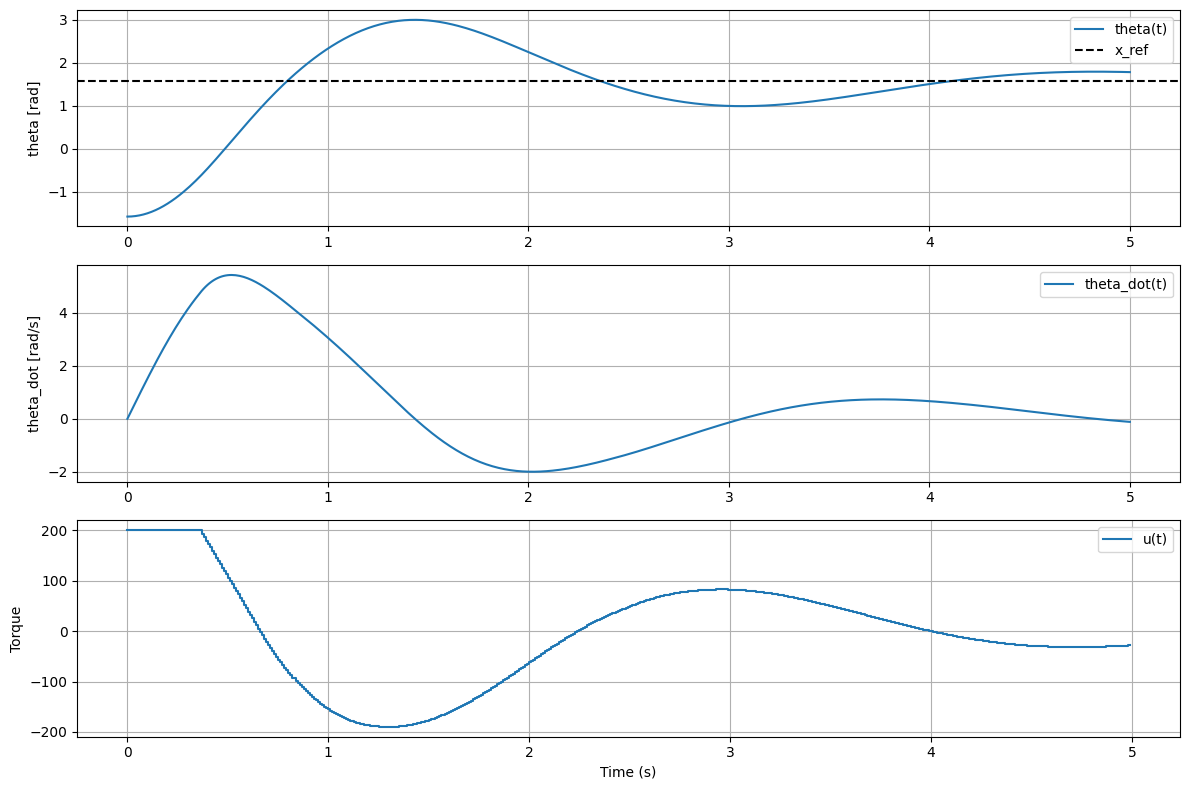

In [6]:
import matplotlib.pyplot as plt

trajectory_x = np.array(trajectory_x)
trajectory_u = np.array(trajectory_u)
time = np.arange(trajectory_x.shape[0]) * dt

plt.figure(figsize=(12,8))

# -----------------------------
# Plot Theta
# -----------------------------
plt.subplot(3,1,1)
plt.plot(time, trajectory_x[:, 0].squeeze(), label="theta(t)")
plt.axhline(x_eq[0], color="k", linestyle="--", label="x_ref")
plt.ylabel("theta [rad]")
plt.legend()
plt.grid(True)

# -----------------------------
# Plot Theta_dot
# -----------------------------
plt.subplot(3,1,2)
plt.plot(time, trajectory_x[:, 1].squeeze(), label="theta_dot(t)")
plt.ylabel("theta_dot [rad/s]")
plt.legend()
plt.grid(True)

# -----------------------------
# Plot Control Input
# -----------------------------
plt.subplot(3,1,3)
plt.step(time[:-1], trajectory_u[:, 0].squeeze(), where="post", label="u(t)")
plt.ylabel("Torque")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
